# Feature selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [3]:
# importing fifa_56
df = pd.read_csv('fifa_56rows.csv')

/Users/cnieto/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.head()

,Unnamed: 0,sofifa_id,short_name,overall,potential,value_eur,wage_eur,age,dob,height_cm,...,mentality_vision,mentality_penalties,mentality_composure,defending_sliding_tackle,goalkeeping_handling,cam,cdm,gk,work_rate_attacking,work_rate_deffensive
0,0,158023,L. Messi,93,93,78000000.0,320000.0,34,1987-06-24,170,...,95,75,96,24,11,93,64,19,2,1
1,1,188545,R. Lewandowski,92,92,119500000.0,270000.0,32,1988-08-21,185,...,81,90,88,19,6,86,66,19,3,2
2,2,20801,Cristiano Ronaldo,91,91,45000000.0,270000.0,36,1985-02-05,187,...,76,88,95,24,11,86,59,20,3,1
3,3,190871,Neymar Jr,91,91,129000000.0,270000.0,29,1992-02-05,175,...,90,93,93,29,9,89,63,20,3,2
4,4,192985,K. De Bruyne,91,91,125500000.0,350000.0,30,1991-06-28,181,...,94,83,89,53,13,89,80,21,3,3


In [64]:
try:
    df.drop('Unnamed: 0',axis=1,inplace=True)
except:
    print('Unnamed column already deleted')
    
try:
    df.set_index('sofifa_id',drop=True)
except:
    print('index already set to sofifa_id')

### replico parte de outliers que hizo Akram (no volver a copiar en el final)

In [65]:
X=df.drop(['wage_eur',
           'short_name',
           'dob',
           'club_name',
           'league_name',
           'club_position',
           'club_joined','nationality_name','nation_position','nation_team_id'],axis=1)
y = df.wage_eur

In [66]:
clf = LocalOutlierFactor(n_neighbors=5)
out=clf.fit_predict(X,y)
df['local_outlier']=out
df['local_outlier'].value_counts()

 1    17702
-1     1463
Name: local_outlier, dtype: int64

In [67]:
isl = LocalOutlierFactor()
out_is=isl.fit_predict(X,y)
df['isolation_outlier']=out_is
df['isolation_outlier'].value_counts()

 1    18449
-1      716
Name: isolation_outlier, dtype: int64

In [68]:
df2=df.drop(df[(df['isolation_outlier']==-1) & (df['local_outlier']==-1)].index)


### f regression (feature_selection)

In [69]:
from sklearn.feature_selection import mutual_info_regression, f_regression

In [70]:
f_values, p_values = f_regression(X,y)

<AxesSubplot:>

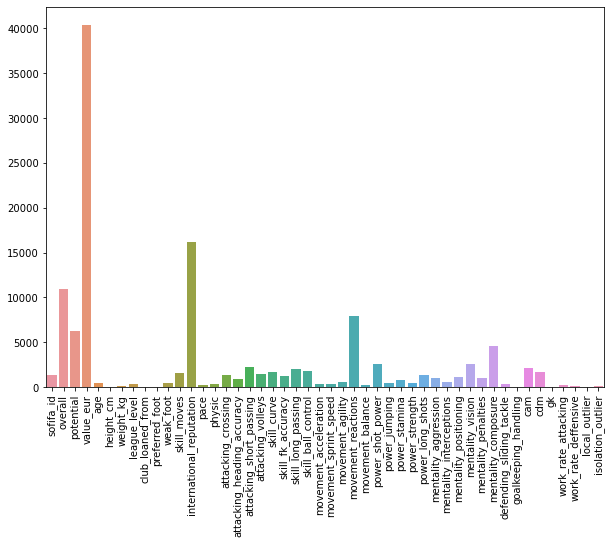

In [75]:
plt.rcParams['figure.figsize'] = (10,7)
plt.xticks(rotation=90)
sns.barplot(x=X.columns, y=f_values)

- As expected, value_eur is the most promiment feature but it is not really interesting for our analysis. Other "featured features" are:  international_reputation, overall, movement_reactions and maybe mentality_compoisure

In [79]:
mut_values = mutual_info_regression(X,y,discrete_features='auto',n_neighbors=3)

<AxesSubplot:>

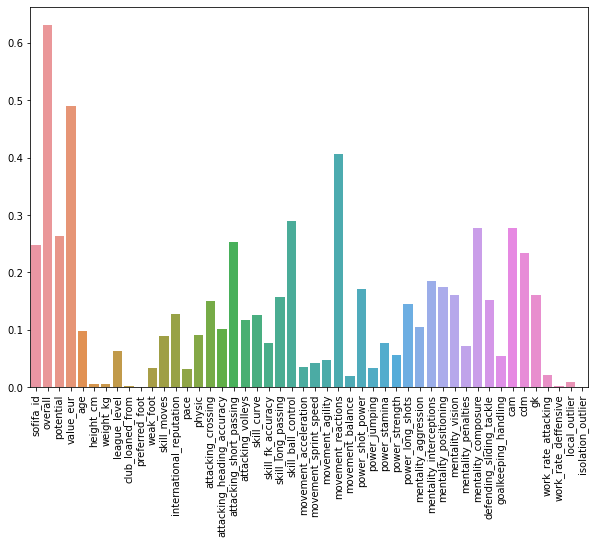

In [81]:
plt.rcParams['figure.figsize'] = (10,7)
plt.xticks(rotation=90)
sns.barplot(x=X.columns, y=mut_values)

- In mutual_infor, value_eur is no longer the most prominent feature, instead it is Overall. Other "featured features" are:  international_reputation, movement_reactions, mentality_compoisure, cam, cdm, skill_ball_control.

- We will not assume that our data has linear depedency, so we will try a model first with mutual_selection features

In [82]:
from sklearn.feature_selection import SelectKBest

In [93]:
select = SelectKBest(score_func=f_regression,k=10)

In [94]:
select.fit(X.drop('value_eur',axis=1),y)

SelectKBest(score_func=<function f_regression at 0x7fa1514c49d0>)

In [95]:
select.get_feature_names_out()

array(['overall', 'potential', 'international_reputation',
       'attacking_short_passing', 'skill_long_passing',
       'movement_reactions', 'power_shot_power', 'mentality_vision',
       'mentality_composure', 'cam'], dtype=object)

- According to Kbest selection model, the top 10 features (skipping value_eur) to use in the model are: 'overall', 'potential', 'international_reputation', 'attacking_short_passing','skill_long_passing','movement_reactions', 'power_shot_power', 'mentality_vision','mentality_composure', 'cam'. We can try models using this 10 features or combinations of them (7,6,5..)